In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [2]:
# Read the data file
df = pd.read_pickle('10_first_ppl_100_rots.pkl')

In [3]:
# --------------------------------------
# SECOND STAGE MODEL TRAINING
# --------------------------------------
# Split training data into separate sets for right and left hand
dflh = df[df.Hand==0]
dfrh = df[df.Hand==1]

# Left hand training
Xlh = list(dflh["Image"])
ylh = dflh["Identity"]
X_trainlh, X_testlh, y_trainlh, y_testlh = train_test_split(Xlh,ylh,test_size=0.2)
model_lid = RandomForestClassifier() # "lid" short for "left hand, identity"
model_lid.fit(X_trainlh,y_trainlh)

# Right hand training
Xrh = list(dfrh["Image"])
yrh = dfrh["Identity"]
X_trainrh, X_testrh, y_trainrh, y_testrh = train_test_split(Xrh,yrh,test_size=0.2)
model_rid = RandomForestClassifier() # "rid" short for "right hand, identity"
model_rid.fit(X_trainrh,y_trainrh)
# --------------------------------------
# END OF SECOND STAGE MODEL TRAINING
# --------------------------------------

RandomForestClassifier()

In [4]:
# -------------------------------------
# FIRST STAGE MODEL TRAINING
# -------------------------------------
X_train = X_trainlh+X_trainrh
X_test = X_testlh+X_testrh
ytr = pd.concat([y_trainrh,y_trainlh])
yte = pd.concat([y_testrh,y_testlh])
y_train = []
y_test = []

for i in range(len(ytr)):
    j = ytr.index[i]
    y_train.append([df["Hand"][j],j])
for i in range(len(yte)):
    j = yte.index[i]
    y_test.append([df["Hand"][j],j])
    
y_train_indexfree = [i[0] for i in y_train]

model_hand = RandomForestClassifier()
model_hand.fit(X_train,y_train_indexfree) # Fit the model fo training data
# -------------------------------------
# END OF FIRST STAGE MODEL TRAINING
# -------------------------------------

RandomForestClassifier()

In [5]:
# --------------------------------------
# MODEL IMPLEMENTATION
# --------------------------------------
pred_hand = model_hand.predict(X_test)

X_lh = []
y_lh = []
X_rh = []
y_rh = []

for i in range(len(pred_hand)):
    if pred_hand[i]==0:
        X_lh.append(X_test[i])
        j = y_test[i][1]
        y_lh.append(df["Identity"][j])
    else:
        X_rh.append(X_test[i])
        j = y_test[i][1]
        y_rh.append(df["Identity"][j])
        
pred_lid = model_lid.predict(X_lh)
pred_rid = model_rid.predict(X_rh)
# --------------------------------------
# END OF MODEL IMPLEMENTATION
# --------------------------------------

In [6]:
# --------------------------------------
# EVALUATION OF RESULTS
# --------------------------------------
# Calculate accuracy
len_lh = len(pred_lid)
len_rh = len(pred_rid)
score_lh = 0
score_rh = 0
score_tot = 0
for i in range(len_lh):
    if pred_lid[i] == y_lh[i]:
        score_lh += 1/len_lh
        score_tot += 1/(len_lh+len_rh)
for i in range(len_rh):
    if pred_rid[i] == y_rh[i]:
        score_rh += 1/len_rh
        score_tot += 1/(len_lh+len_rh)
        
# Print the result
print(score_lh)
print(score_rh)
print(score_tot)
# --------------------------------------
# END OF EVALUATION OF RESULTS
# --------------------------------------

0.11047619047619064
0.11052631578947392
0.11050000000000008


In [7]:
pred_id = np.concatenate((pred_lid,pred_rid))
y_both = np.concatenate((y_lh,y_rh))

Text(33.0, 0.5, 'Truth')

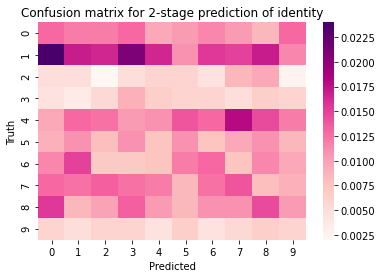

In [10]:
# Confusion matrix
cm = confusion_matrix(pred_id, y_both, normalize='all') # Remove 'normalize="all"' to get absolute numbers
plt.figure()
sn.heatmap(cm, annot=False, cmap='RdPu')
plt.title('Confusion matrix for 2-stage prediction of identity')
plt.xlabel('Predicted')
plt.ylabel('Truth')